In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

In [2]:
torch.cuda.is_available()

False

# Helper functions

In [5]:
# note that these methods break if you use fastai v1.0
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by class_index           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

In [6]:
def load_image(idx, df, ax=None, annotate=True):
    """Helper function to load and annotate image"""
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    Z_true, Z_pred = df.iloc[idx]
    name = df.index[idx]
    
    # get image
    image = plt.imread(f'{PATH}/test/{name}.jpg')
    ax.imshow(image)
    ax.axis('off')
    
    # label
    if annotate:
        fontdict = dict(color='white', size=18)
        #ax.text(0.5, 0.9, f'{name}', fontdict=fontdict, transform=ax.transAxes, ha='center', va='bottom')
        ax.text(0.95, 0.125, r'$Z_{\rm true}$' + f' = {Z_true:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')
        ax.text(0.95, 0.025, r'$Z_{\rm pred}$' + f' = {Z_pred:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')

# Inspecting data

In [8]:
PATH = os.path.abspath('..')
!ls {PATH}

catalogs  get_images.sh  images  models  notebook  src	test  tmp  train


In [9]:
!ls {PATH}/catalogs

test.csv  test.filenames  train.csv  train.filenames


In [10]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

display(df.sample(5, random_state=1234))

# save a subset (20%) for validation
n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2)

,oh_p50
objID,
1237657119477334357,8.459984
1237658917995086018,8.826601
1237658493346644079,8.583775
1237657775005630813,8.994787
1237668496849830008,8.984790


In [11]:
display(df.describe())

,oh_p50
count,400.000000
mean,8.901004
std,0.199803
min,8.133490
25%,8.824294
50%,8.950793
75%,9.047316
max,9.260791


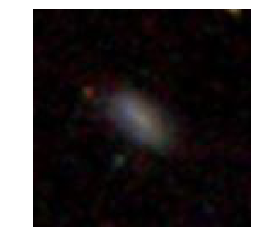

In [12]:
image = plt.imread(f'{PATH}/train/1237657119477334357.jpg')
plt.imshow(image)
plt.axis('off');

Another set of helper functions

In [25]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

def rmse_np(x, y):
    return np.sqrt(np.mean((x-y)**2))

# Train a simple convnet (using Pytorch/fastai)

## Simple convnet 
Inspired by a [notebook](https://github.com/richardagalvez/basic-intro-pytorch) by R. Galavez

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Construct a `learner`

In [80]:
# image size
sz = 128

# batch size
bs = 4

# architecture
arch = SimpleCNN()

In [81]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

In [82]:
# construct fastai learner object 
learn = ConvLearner.from_model_data(arch, data)

# IMPORTANT! make sure we're using the RMSE loss function
learn.crit = rmse

In [83]:
display(learn)

display([o.numel() for o in learn.model.parameters()])

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc): Linear(in_features=32768, out_features=1, bias=True)
)

[1200, 16, 16, 16, 12800, 32, 32, 32, 32768, 1]

In [84]:
display(learn.summary())

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 1216)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 16, 64, 64]

## Understanding the number of parameters
* **(Layer 1)** We find $16 \times 5 \times 5 \times 32 = 1200$, plus $16$ (for bias terms), and then $2\times 16$ for the BatchNorm mean and standard deviation. ✓
* **(Layer 2)** $32 \times (5 \times 5 \times 16 + 1) = 12832$, and then $2 \times 32$ for BatchNorm ✓
* **(Fully connected)** $32 \times 32 \times 32 + 1 = 32769$ ✓

## Finding an optimal learning rate
See [L. Smith (2015)](https://arxiv.org/abs/1506.01186)

 75%|███████▌  | 60/80 [00:05<00:01, 10.59it/s, loss=23.6]


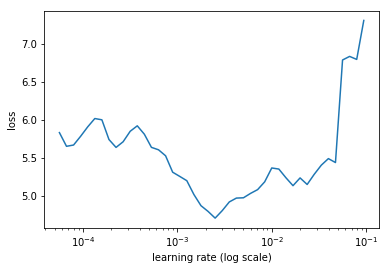

In [85]:
learn.lr_find()
learn.sched.plot()

Recall that we only have 320 training + 80 validation examples, so for a batch size of 4, we expect 80 iterations per epoch. (A batch size of 4 is tiny, but basically unavoidable!)

Anyway, here it appears that at $3 \times 10^{-3}$ the learning rate bottoms out. We'll select about an order of magnitude below this, or $3\times 10^{-4}$, since that tends to work well.

epoch      trn_loss   val_loss                            
    0      1.568777   1.814626  
    1      1.09155    1.494734                            



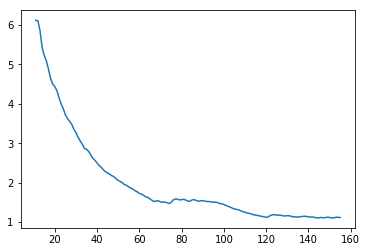

In [86]:
lr = 3e-4

# train model for two epochs
learn.fit(lr, n_cycle=2)

# show loss vs. iteration
learn.sched.plot_loss()

Since the RMSE still appears to be improving, we'll keep training with the same learning rate

epoch      trn_loss   val_loss                             
    0      0.626103   0.241533  
    1      0.634271   0.55254                              



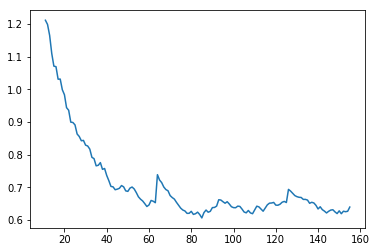

In [87]:
learn.fit(lr, n_cycle=2)
learn.sched.plot_loss()

Let's now *anneal* the learning rate by an order of magnitude and fit two more epochs.

epoch      trn_loss   val_loss                             
    0      0.477273   0.377702  
    1      0.360254   0.289297                             



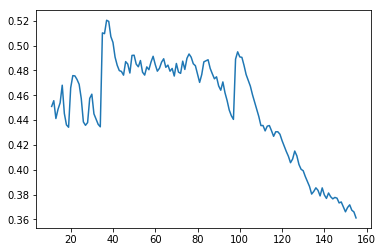

In [88]:
lr = 3e-5
learn.fit(lr, n_cycle=2)
learn.sched.plot_loss()

More annealing and training.

epoch      trn_loss   val_loss                             
    0      0.334416   0.191887  
    1      0.292916   0.192347                             



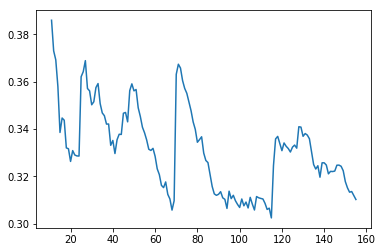

In [89]:
lr = 1e-5
learn.fit(lr, n_cycle=2)
learn.sched.plot_loss()

Here the validation loss is bottoming out at about RMSE $\approx 0.19$.

## Making predictions

In [90]:
# run test (no augmentation)
Z_pred = learn.predict(is_test=True)

In [27]:
# construct answer key
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)
df_test = pd.read_csv(f'{PATH}/catalogs/test.csv', index_col=0)
Z_true = df_test.loc[test_names].values

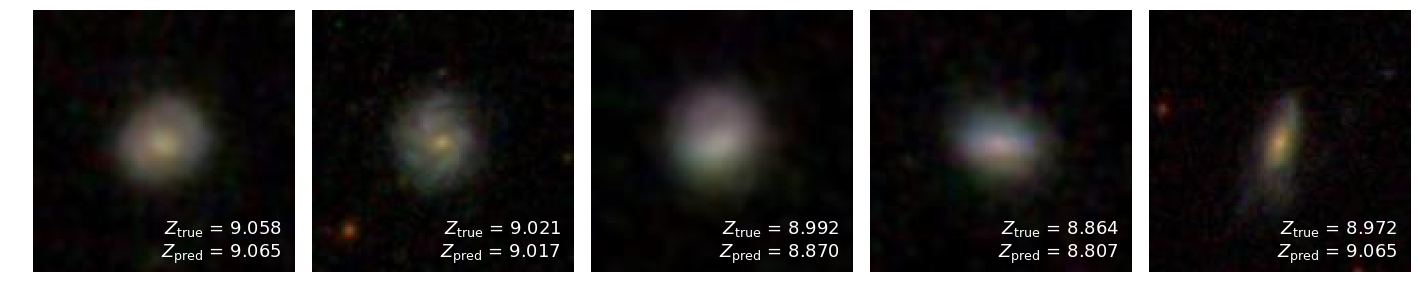

In [95]:
# show results
res = pd.DataFrame({'Z_pred': Z_pred.flatten(), 'Z_true': Z_true.flatten()}, index=test_names)

# random selection of five galaxies
rand = res.sample(frac=1., random_state=1234)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)

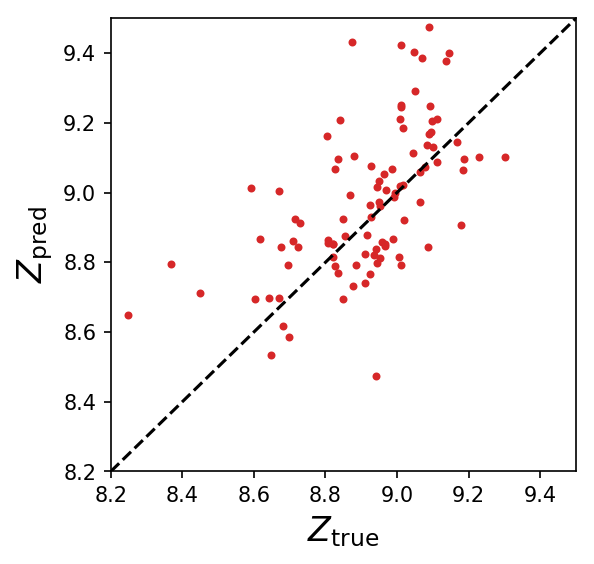

In [110]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

Not bad for a net with only two convolutional layers!

# More efficient training with the same convnet?

In [126]:
sz = 128
bs = 4
arch = SimpleCNN()

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

# remember that you need to re-set the loss function criterion EVERY TIME
learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

Here we will use a different strategy. We'll now use a flat learning rate for two epochs, cosine annealing for one epoch, and then cosine anneal for two epochs, and then cosine anneal for four epochs (a total of three *cycles* and seven *epochs*).

Note that dropout layers sometimes make the training loss worse than the validation loss. (This is also only the case when we are not overfitting.)

In [132]:
# two epochs of flat learning rate training
learn.fit(3e-4, 2) 

# and then cosine annealing schedule
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      0.590194   0.266521  
    1      0.526866   0.371232                             



epoch      trn_loss   val_loss                             
    0      0.299621   0.1701    
    1      0.297599   0.277092                             
    2      0.266534   0.151013                             
    3      0.287543   0.161214                             
    4      0.376983   0.259972                             
    5      0.296416   0.18358                              
    6      0.237003   0.13989                              



[array([0.13989])]

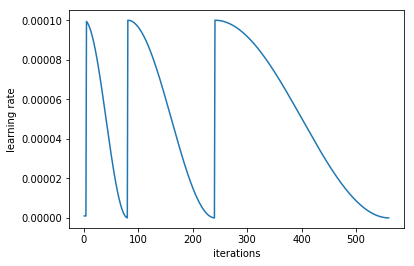

In [133]:
learn.sched.plot_lr()

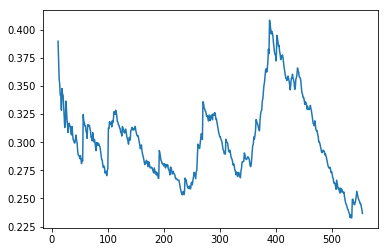

In [135]:
learn.sched.plot_loss()

In [136]:
Z_pred = learn.predict(is_test=True)

In [140]:
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.142 dex


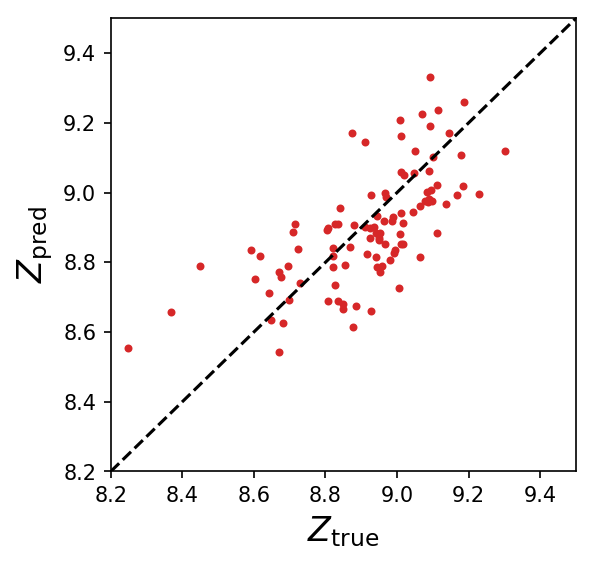

In [141]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# A deeper convnet
Inspired by the [fastai notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb)

In [45]:
class ConvBnNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, layers[0], kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(2))
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, padding=2),
                nn.BatchNorm2d(layers[i + 1]),
                nn.ReLU(),
                nn.MaxPool2d(2))
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], 1)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x).view(-1)

In [55]:
arch = ConvBnNet([32, 64, 128])
sz = 128
bs = 4

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

In [47]:
display(learn)
display([o.numel() for o in learn.model.parameters()])

ConvBnNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)

[4704, 32, 51200, 64, 64, 64, 204800, 128, 128, 128, 128, 1]

In [48]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 32, 64, 64]),
                           ('trainable', True),
                           ('nb_params', 4736)])),
             ('MaxPool2d-2',
              OrderedDict([('input_shape', [-1, 32, 64, 64]),
                           ('output_shape', [-1, 32, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 32, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 51264)])),
             ('BatchNorm2d-4',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-5',
              Orde

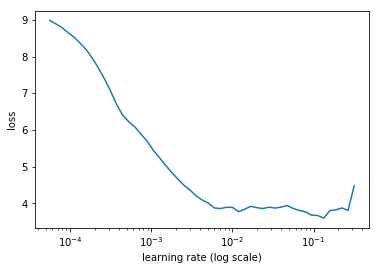

In [49]:
learn.lr_find()
learn.sched.plot()

In [56]:
lr = 1e-3
learn.fit(lr, 2)

epoch      trn_loss   val_loss                             
    0      0.906096   0.23832   
    1      0.468211   0.152998                             


[array([0.153])]

epoch      trn_loss   val_loss                             
    0      0.398086   0.554547  
    1      0.254466   0.204432                             


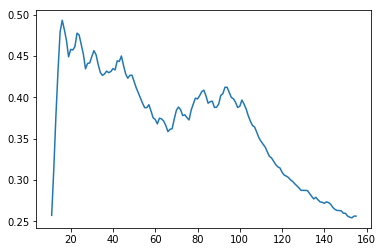

In [58]:
# some cosine annealing
learn.fit(3e-4, 1, cycle_len=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.203411   0.140173  
    1      0.213966   0.15441                              
    2      0.197363   0.166735                             
    3      0.197832   0.136884                             


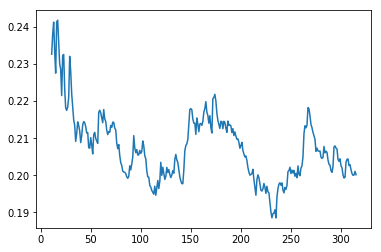

In [59]:
learn.fit(1e-4, 1, cycle_len=4)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.185488   0.134698  
    1      0.185831   0.135784                             
    2      0.184467   0.137492                             
    3      0.182598   0.136874                             
    4      0.182704   0.136637                             
    5      0.175818   0.131765                             
    6      0.169855   0.133961                             


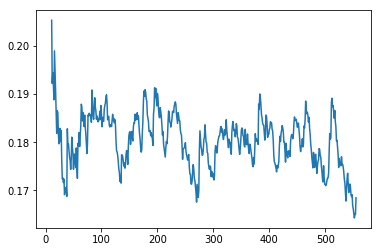

In [60]:
learn.fit(3e-5, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

Not bad for my laptop...

In [61]:
Z_pred = learn.predict(is_test=True)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.242 dex


## Use test-time augmentation

In [62]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.240 dex                        


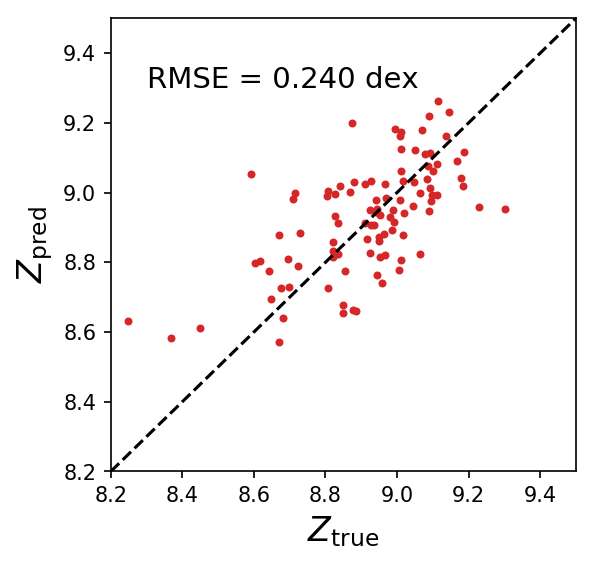

In [67]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a `fastai` resnet model

In [79]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)
learn = ConvLearner.pretrained(arch, data, pretrained=False, precompute=False)
learn.crit = rmse

In [75]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

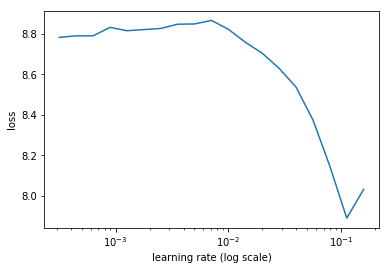

In [80]:
learn.lr_find()
learn.sched.plot()

In [81]:
lr = 1e-2

learn.fit(lr, 4)

epoch      trn_loss   val_loss                            
    0      5.040589   1.245641  
    1      3.68639    0.686697                            
    2      3.039119   2.184811                            
    3      2.613725   0.755013                            


[array([0.75501])]

epoch      trn_loss   val_loss                            
    0      2.07649    0.333188  
    1      1.76433    0.384119                            
    2      1.604552   0.397009                            
    3      1.474902   0.460369                            
    4      1.421429   0.253297                            
    5      1.377148   0.265647                            
    6      1.32207    0.207658                            
    7      1.241122   0.210985                            
    8      1.189772   0.384506                            
    9      1.131184   0.196766                            
    10     1.050414   0.179477                            
    11     0.963612   0.167081                             
    12     0.977884   0.165015                             
    13     0.966783   0.158044                             


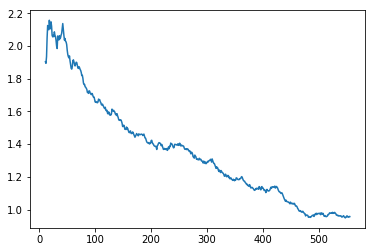

In [82]:
learn.fit(1e-3, 3, cycle_len=2, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.940007   0.162697  
    1      0.983215   0.16337                              
    2      0.98797    0.175117                             
    3      0.98095    0.20206                              
    4      0.947736   0.14976                              
    5      0.933169   0.161095                             
    6      0.93711    0.175967                             


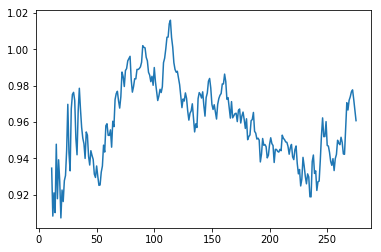

In [83]:
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [84]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.167 dex                        


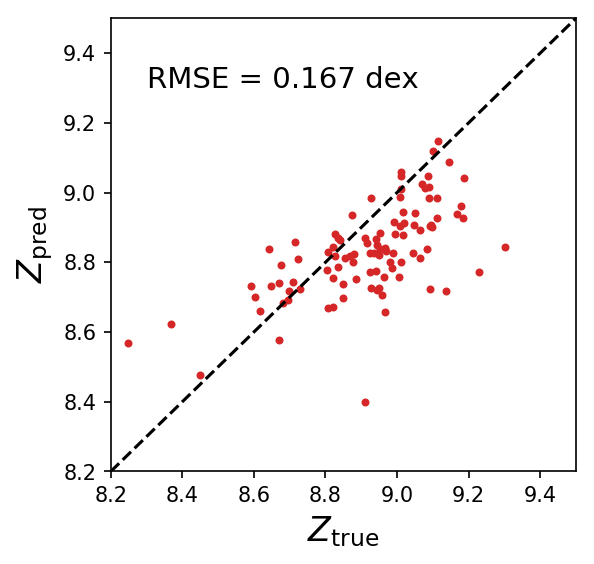

In [85]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a pretrained (frozen) resnet

In [90]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)
learn = ConvLearner.pretrained(arch, data, pretrained=True, precompute=True)
learn.crit = rmse

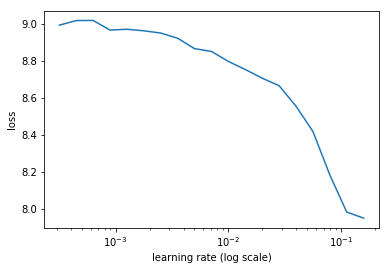

In [91]:
learn.lr_find()
learn.sched.plot()

In [92]:
lr = 1e-2

learn.fit(lr, 20)

epoch      trn_loss   val_loss                            
    0      4.73643    3.049239  
    1      3.37763    2.509586                            
    2      2.879929   1.812231                            
    3      2.396885   1.459061                            
    4      2.179243   1.323556                            
    5      2.146751   1.258777                            
    6      1.853131   1.150953                            
    7      1.80779    0.733549                            
    8      1.664958   1.12164                             
    9      1.483553   0.911512                             
    10     1.332845   0.675934                             
    11     1.126252   0.626744                            
    12     1.069244   0.584106                            
    13     0.979729   0.558698                             
    14     0.902856   0.656744                             
    15     0.886398   0.429181                             
    16     0.86199

[array([0.28278])]

epoch      trn_loss   val_loss                             
    0      0.52078    0.275066  
    1      0.487762   0.241241                             
    2      0.473475   0.237766                             
    3      0.469938   0.221098                             
    4      0.433653   0.237272                             
    5      0.440165   0.220359                             
    6      0.439538   0.224347                             
    7      0.427689   0.202986                             
    8      0.420949   0.185637                             
    9      0.403784   0.210867                             
    10     0.389237   0.192841                             
    11     0.374015   0.173996                             
    12     0.361625   0.184636                             
    13     0.349406   0.181395                             
    14     0.348949   0.176532                             
    15     0.357364   0.178426                             
    16 

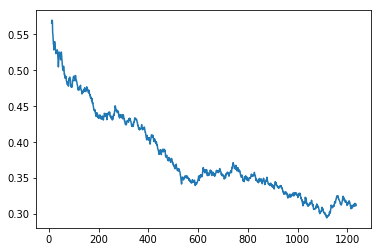

In [93]:
learn.fit(1e-3, 5, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.297341   0.158666  
    1      0.30194    0.156313                             
    2      0.310903   0.158865                             
    3      0.320094   0.15518                              
    4      0.311704   0.165785                             
    5      0.308518   0.156599                             
    6      0.32594    0.1627                               
    7      0.328705   0.160425                             
    8      0.317324   0.154223                             
    9      0.319317   0.154191                             
    10     0.316006   0.160042                             
    11     0.313347   0.153305                             
    12     0.308376   0.15634                              
    13     0.30203    0.158372                             
    14     0.310134   0.155409                             
    15     0.310737   0.167545                             
    16 

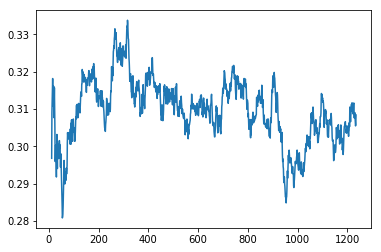

In [94]:
learn.fit(1e-4, 5, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.298241   0.157853  
    1      0.303127   0.155094                             
    2      0.309612   0.157095                             
    3      0.298665   0.156718                             
    4      0.295588   0.162357                             
    5      0.301726   0.157545                             
    6      0.304359   0.163111                             
    7      0.302966   0.153663                             
    8      0.297866   0.164972                             
    9      0.313791   0.176941                             
    10     0.305096   0.160361                             
    11     0.302758   0.156892                             
    12     0.295572   0.162155                             
    13     0.307484   0.156021                             
    14     0.300103   0.151763                             
    15     0.291363   0.158694                             
    16 

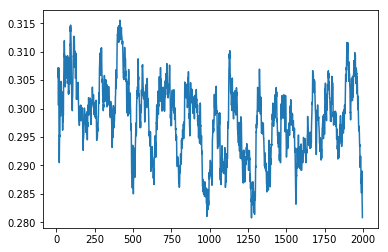

In [95]:
learn.fit(1e-4, 1, cycle_len=50)
learn.sched.plot_loss()

In [96]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.155 dex                        


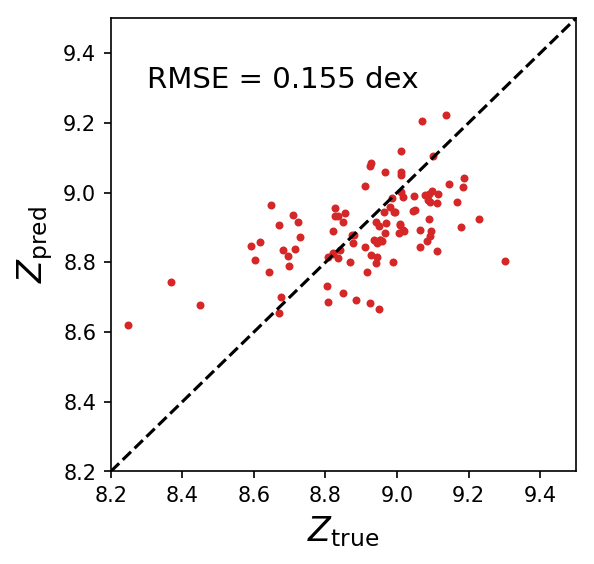

In [97]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a pretrained resnet with layered learning rates

In [98]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)
learn = ConvLearner.pretrained(arch, data, pretrained=True, precompute=True)
learn.crit = rmse

## Initial fine-tuning

In [99]:
learn.fit(1e-2, 20)
learn.fit(1e-3, 20)

epoch      trn_loss   val_loss                            
    0      5.017535   3.773864  
    1      3.40919    1.988058                            
    2      2.745528   1.603919                            
    3      2.40939    1.316402                            
    4      2.072454   1.207063                            
    5      1.936631   1.865013                            
    6      1.810931   0.762532                            
    7      1.700375   1.217062                            
    8      1.567141   0.806654                            
    9      1.445889   0.755365                            
    10     1.446226   0.829887                            
    11     1.365904   0.530693                            
    12     1.180381   0.566474                            
    13     1.001293   0.432909                            
    14     0.900216   0.507783                             
    15     0.831301   0.495333                             
    16     0.767201  

epoch      trn_loss   val_loss                             
    0      0.438698   0.229796  
    1      0.44155    0.228005                             
    2      0.435087   0.201315                             
    3      0.419394   0.189127                             
    4      0.380139   0.244286                             
    5      0.382966   0.200044                             
    6      0.37318    0.21886                              
    7      0.348893   0.191231                             
    8      0.34187    0.191279                             
    9      0.34898    0.191752                             
    10     0.337848   0.178154                             
    11     0.339597   0.164537                             
    12     0.337595   0.166954                             
    13     0.317725   0.179752                             
    14     0.318633   0.168968                             
    15     0.315715   0.16337                              
    16 

[array([0.16903])]

In [100]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

## Unfreeze early layer groups

In [101]:
learn.unfreeze()

In [102]:
lrs = 1e-3 / np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      0.311775   0.175827  
    1      0.314564   0.174354                             
    2      0.302786   0.168306                             
    3      0.308561   0.178642                             
    4      0.297887   0.171462                             
    5      0.288642   0.158033                             
    6      0.29064    0.156879                             


[array([0.15688])]

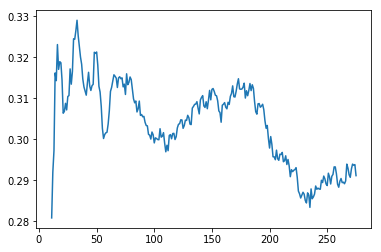

In [103]:
learn.sched.plot_loss()

In [104]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.146 dex                        


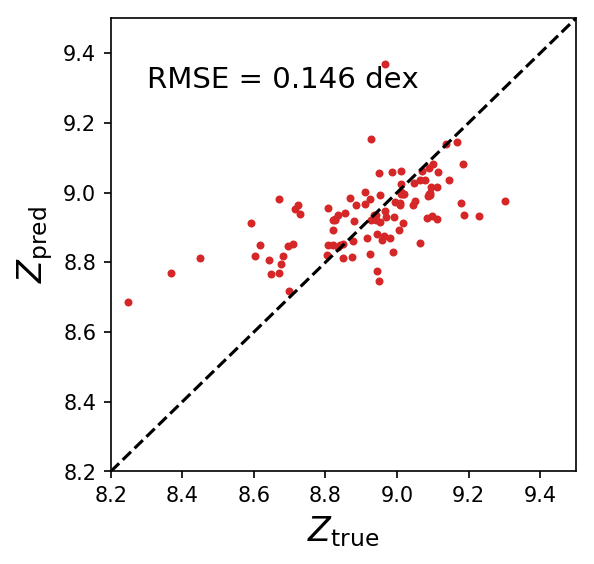

In [105]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');